In [1]:
from pathlib import Path
import sys
sys.path.append(r"C:\Users\esteb\escarabajos2\libraries")  # Replace with actual path to libraries under git repo
from l1050_preprocessing import l1050_preprocessing
import pandas as pd

In [2]:
main_dir = Path(r"E:\downloads\OCT\OCT\ASCII")
t_file = main_dir/"vidrio_portaobjetos_T.Sample.ASC"
r_file =  main_dir/ "vidrio_R.Sample.ASC"


In [3]:
#preprocessing
path_files = [t_file, r_file]
str_files = [str(item) for item in path_files]

l1050_preprocessing(str_files)

Reading E:\downloads\OCT\OCT\ASCII\vidrio_portaobjetos_T.Sample.ASC -> columns: ['wavelength', '%T']
Reading E:\downloads\OCT\OCT\ASCII\vidrio_R.Sample.ASC -> columns: ['wavelength', '%R']


In [4]:
preprocessed_dir = main_dir / "l1050_preprocessing"
t_file_pp = preprocessed_dir/"vidrio_portaobjetos_T.Sample.ASC"
r_file_pp =  preprocessed_dir/ "vidrio_R.Sample.ASC"

In [5]:
#load dataframes
t_df = pd.read_csv(t_file_pp, delimiter = "\t", decimal= ",")
r_df = pd.read_csv(r_file_pp, delimiter = "\t", decimal= ",")
t_df

,wavelength,%T,%T_smooth
0,1999.0,93.2505,93.2443534872549
1,1998.0,93.364492,93.28869498305322
2,1997.0,93.223931,93.32181287461755
3,1996.0,93.240124,93.34469304807155
4,1995.0,93.427702,93.35832138953892
...,...,...,...
1745,254.0,-0.15255699999999733,-0.10693993437118166
1746,253.0,-0.1542239999999973,-0.15026475278316198
1747,252.0,-0.17089799999999733,-0.18735152318106496
1748,251.0,-0.22974599999999734,-0.22057504295051156


In [6]:
r_df

,wavelength,%R,%R_smooth
0,1999.0,8.300723,8.30753560751634
1,1998.0,8.302083,8.295005005275444
2,1997.0,8.302092,8.28892854028945
3,1996.0,8.283211,8.28815389217123
4,1995.0,8.269857,8.291528740533652
...,...,...,...
1745,254.0,6.418137000000001,6.434896003979028
1746,253.0,6.517743,6.47729872882281
1747,252.0,6.494960000000001,6.517023081530558
1748,251.0,6.497222000000001,6.552634730905692


In [7]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd

import numpy as np
import pandas as pd
from scipy.optimize import minimize

def estimate_nk_from_smoothed_df(t_df: pd.DataFrame, r_df: pd.DataFrame, thickness_nm: float) -> pd.DataFrame:
    """
    Estimate complex refractive index (n + ik) from DataFrames containing smoothed %T and %R data.

    Parameters:
        t_df (pd.DataFrame): DataFrame with columns ['wavelength', '%T_smooth']
        r_df (pd.DataFrame): DataFrame with columns ['wavelength', '%R_smooth']
        thickness_nm (float): Film thickness in nanometers

    Returns:
        pd.DataFrame: DataFrame with columns ['wavelength', 'n', 'k']
    """
    
    # Merge on wavelength
    merged_df = pd.merge(t_df[['wavelength', '%T_smooth']],
                         r_df[['wavelength', '%R_smooth']],
                         on='wavelength',
                         how='inner')

    # Filter wavelength range
    merged_df = merged_df[(merged_df['wavelength'] > 250) & (merged_df['wavelength'] < 1500)]

    results = []

    for _, row in merged_df.iterrows():
        wavelength_nm = row['wavelength']
        T = row['%T_smooth'] 
        R = row['%R_smooth'] 

        if pd.isna(R) or pd.isna(T) or T >= 0.99 and R <= 0.01:
            results.append((wavelength_nm, np.nan, np.nan))
            continue

        wavelength_m = wavelength_nm * 1e-9
        thickness_m = thickness_nm * 1e-9

        def fresnel_loss(params):
            n, k = params
            if n <= 0 or k < 0:
                return 1e6

            n_complex = n + 1j * k
            r = (n_complex - 1) / (n_complex + 1)
            R_calc = abs(r)**2

            alpha = 4 * np.pi * k / wavelength_m
            denom = 1 - R_calc**2 * np.exp(-2 * alpha * thickness_m)
            if denom == 0:
                return 1e6

            T_calc = (1 - R_calc)**2 * np.exp(-alpha * thickness_m) / denom
            return (R_calc - R)**2 + (T_calc - T)**2

        bnds = [(0.5, 4), (0, 2)]
        result = minimize(fresnel_loss, x0=(1.5, 0.1), bounds=bnds)

        if result.success:
            n, k = result.x
        else:
            n, k = np.nan, np.nan

        results.append((wavelength_nm, n, k))

    return pd.DataFrame(results, columns=['wavelength', 'n', 'k']).set_index('wavelength')



In [11]:
t_df["wavelength"] = pd.to_numeric(t_df["wavelength"], errors="coerce")
r_df["wavelength"] = pd.to_numeric(r_df["wavelength"], errors="coerce")

t_df["%T_smooth"] = t_df["%T_smooth"].astype(float)/100
r_df["%R_smooth"] = r_df["%R_smooth"].astype(float)/100
nk_df = estimate_nk_from_smoothed_df(t_df, r_df, thickness_nm=500)


Index(['n', 'k'], dtype='object')

In [15]:
nk_df

,n,k
wavelength,,
1499.0,1.177426,0.621555
1498.0,1.177306,0.621327
1497.0,1.177186,0.621100
1496.0,1.177066,0.620872
1495.0,1.176946,0.620645
...,...,...
255.0,1.020112,0.204432
254.0,1.020664,0.203908
253.0,1.020466,0.203325


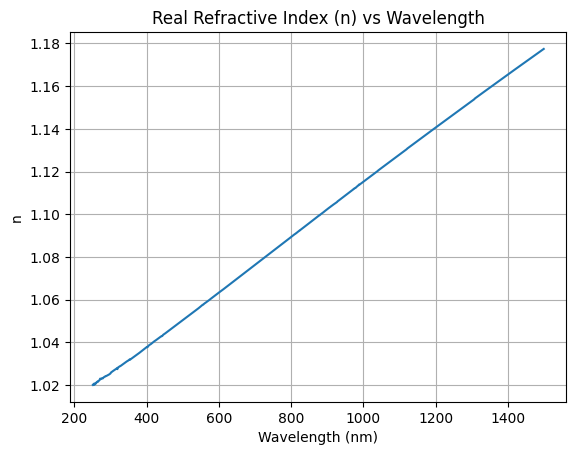

In [22]:
nk_df["n"].plot(title="Real Refractive Index (n) vs Wavelength")
plt.xlabel("Wavelength (nm)")
plt.ylabel("n")
plt.grid(True)
plt.show()

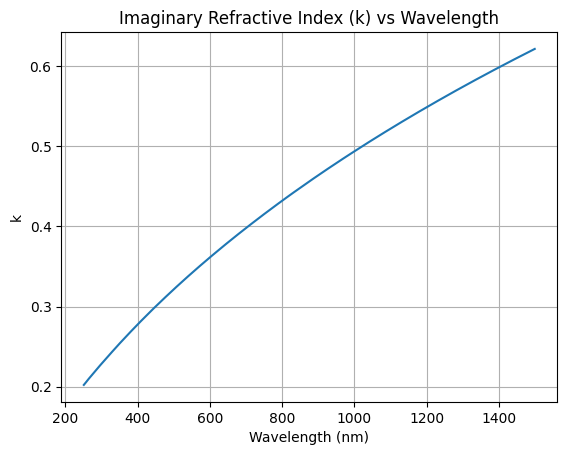

In [23]:
nk_df["k"].plot(title="Imaginary Refractive Index (k) vs Wavelength")
plt.xlabel("Wavelength (nm)")
plt.ylabel("k")
plt.grid(True)
plt.show()